# WRF Forecast to Power Tutorial

This tutorial will walk through the process of going from a WRF forecast model data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load Forecast Data](#Load-Forecast-Data)
2. [Pull a location from NY-Sun Database and extract meteorological data](#Pull-a-location-from-NY-Sun-Database-and-extract-meteorological-data)
2. [Module-Specific Power Calculation](#Module-Specific-Power-Calculationn)
2. [Nameplate Capacity-Based Power Calculation](#Nameplate-Capacity-Based-Power-Calculation)

This tutorial requires pvlib from [my GitHub repo](https://github.com/jeffreysward/pvlib-python)!

Authors:
* Jeffrey Sward (jas983@cornell.edu), Cornell University, November 2020

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from optwrf import runwrf as rw
from optwrf import postwrf as pw
from optwrf import util

# Import the pvlib module
import pvlib
from pvlib.wrfcast import WRF
from pvlib.location import Location
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.modelchain import ModelChain

No module named 'pyresample'


## Load Forecast Data

In [2]:
# Specify the forecast model as WRF
fm = WRF()

In [3]:
# Specify the absolute path to WRF data file (wrfout*.nc)
wrfout_dir = '/Users/jeffreysward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/wrf_data/data/wrf/'
wrfout_file = 'wrfout_d01_2020-06-30_00:00:00'

In [37]:
# Get raw variables from the wrfout.nc file
# If you like, you can specify a start and end time here, but it needs to be contianed within the 
# WRF timeframe and the data will be sliced accordingly. Otherwise, the method assumes that you want 
# the full time horizon available in the WRF datafile.
forecast_data = fm.get_data(wrfout_dir, wrfout_file, start='07-01-2020', end='07-02-2020 12')
forecast_data

<xarray.Dataset>
Dimensions:  (south_north: 82, west_east: 110, Time: 37, bottom_top: 35)
Coordinates:
    XLONG    (south_north, west_east) float32 -83.34 -83.21 ... -67.75 -67.6
    XLAT     (south_north, west_east) float32 36.88 36.89 36.9 ... 45.59 45.58
    XTIME    (Time) float32 1.44e+03 1.5e+03 1.56e+03 ... 3.54e+03 3.6e+03
  * Time     (Time) datetime64[ns] 2020-07-01 ... 2020-07-02T12:00:00
Dimensions without coordinates: south_north, west_east, bottom_top
Data variables:
    T2       (Time, south_north, west_east) float32 295.7 295.2 ... 293.1 293.3
    U10      (Time, south_north, west_east) float32 0.4813 0.5105 ... 1.876
    V10      (Time, south_north, west_east) float32 -0.02025 -0.1091 ... 1.92
    CLDFRA   (Time, bottom_top, south_north, west_east) float32 0.0 0.0 ... 0.0
    COSZEN   (Time, south_north, west_east) float32 0.185 0.1833 ... 0.4945
    SWDDNI   (Time, south_north, west_east) float32 368.9 468.3 ... 686.8 631.8
    SWDDIF   (Time, south_north, west_east) float32 45.53 35.79 ... 90.93 100.2
Attributes: (12/139)
    FieldType:                       104
    MemoryOrder:                     XY 
    description:                     TEMP at 2 M
    units:                           K
    stagger:                         
    coordinates:                     XLONG XLAT XTIME
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [22]:
# Process the data to use with PVLib
forecast_data = fm.process_data(forecast_data)

The ``xarray Dataset`` below shows which variables are included in the processed WRF data

In [23]:
forecast_data.head()

<xarray.Dataset>
Dimensions:     (Time: 5, south_north: 5, west_east: 5)
Coordinates:
    XLONG       (south_north, west_east) float32 -83.34 -83.21 ... -82.98 -82.85
    XLAT        (south_north, west_east) float32 36.88 36.89 ... 37.34 37.35
  * Time        (Time) datetime64[ns] 2020-07-01 ... 2020-07-01T04:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    temp_air    (Time, south_north, west_east) float32 22.57 22.05 ... 19.43
    wind_speed  (Time, south_north, west_east) float32 0.4817 0.5221 ... 2.358
    ghi         (Time, south_north, west_east) float32 113.8 121.6 ... 0.0 0.0
    dni         (Time, south_north, west_east) float32 368.9 468.3 ... 0.0 0.0
    dhi         (Time, south_north, west_east) float32 45.53 35.79 ... 0.0 0.0
Attributes: (12/139)
    FieldType:                       104
    MemoryOrder:                     XY 
    description:                     TEMP at 2 M
    units:                           K
    stagger:                         
    coordinates:                     XLONG XLAT XTIME
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

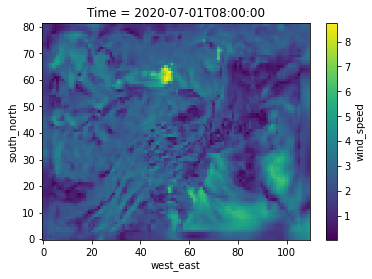

In [24]:
# Visualize the wind speed data across the entire WRF domina for a single time step
forecast_data.wind_speed.isel(Time=8).plot()
plt.show()

## Extract meteorological data for a specific location

In [25]:
# Get location data from NY-Sun Database
location = Location(latitude=40.7484, longitude=-73.9967)
location

Location: 
  name: None
  latitude: 40.7484
  longitude: -73.9967
  altitude: 0
  tz: UTC

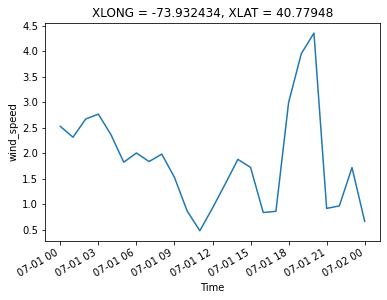

In [26]:
# Extract data for this location from the processed WRF data
# Here is a way of doing it that works well for multiple points 
# (i.e., you create a Kdtree_ll_to_xy class and query it when you need a pair of indicies)
ns = util.Kdtree_ll_to_xy(forecast_data,'XLAT','XLONG')
iy,ix = ns.query(location.latitude, location.longitude)
forecast_data.wind_speed.isel(west_east=ix, south_north=iy).plot()

In [27]:
# Create a new Dataset containing only data for this location
location_forecast = forecast_data.isel(west_east=ix, south_north=iy)

In [28]:
# Convert it to a pandas.DataFrame (required for PVLib)
location_forecast = location_forecast[['dni', 'dhi', 'ghi', 'temp_air', 'wind_speed']].to_dataframe()

## Module-Specific Power Calculation

In [29]:
# Specify a module/inverter pair for the PVSystem
sandia_modules = retrieve_sam('SandiaMod')
sapm_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [30]:
# Specify the PVSystem (i.e., what the system looks like that we are calculating the power for)
# Perhaps we can pull this information from the NY-Sun Database at some point as well, 
# but it would certainly take a long time to process each time, 
# so I would probably need to save it to a local database.
temperature_model_parameters = (pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'])
system = PVSystem(module_parameters=module,
                  inverter_parameters=inverter,
                  temperature_model_parameters=temperature_model_parameters, 
                  surface_tilt=location.latitude)
system

PVSystem:
  name: None
  Array:
    name: None
    mount: FixedMount(surface_tilt=40.7484, surface_azimuth=180, racking_model=None, module_height=None)
    module: None
    albedo: 0.25
    module_type: None
    temperature_model_parameters: {'a': -3.56, 'b': -0.075, 'deltaT': 3}
    strings: 1
    modules_per_string: 1
  inverter: None

In [31]:
# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, location)

In [32]:
# extract relevant data for model chain
mc.run_model(location_forecast)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

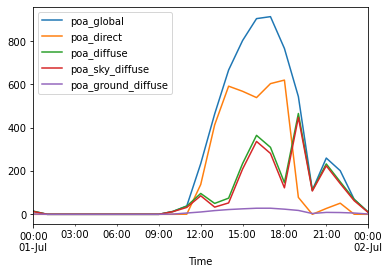

In [33]:
# This plot shows the irradiance (I assume the y-axis units are W/m^2, but I'm not sure).
mc.results.total_irrad.plot()
plt.show()

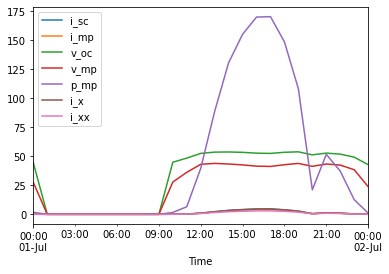

In [34]:
# This plot shows the results of the DC model (I assume the y-axis units are W, but I'm not sure).
mc.results.dc.plot()
plt.show()

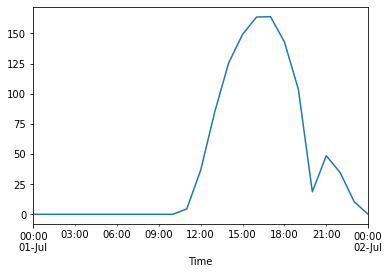

In [35]:
# This plot shows the AC power output (I assume the y-axis units are W, but I'm not sure).
# I reason this based on the fact the the module is rated to 220W, and the example here is for Jan 25.
mc.results.ac.plot()
plt.show()

## Nameplate Capacity-Based Power Calculation

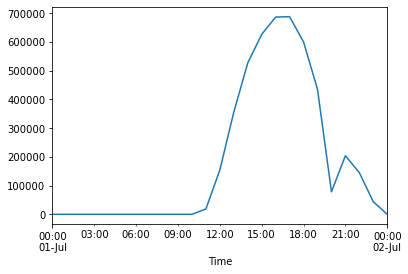

In [36]:
# We now scale the above profile based upon the total nameplate capacity
totalnameplatewdc = 923.9800 * 1000  # convert from kWdc to Wdc
ac_power = mc.results.ac/220 * totalnameplatewdc
ac_power.plot() # Note that this plot is in Watts
plt.show()